In [ ]:
# ============================================================================
# 0. Configuration
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)

# Path to your file in Drive
DATA_PATH = Path('/content/drive/MyDrive/home_insurance.csv')

print("Using pandas version:", pd.__version__)
print("Dataset path:", DATA_PATH)


Using pandas version: 2.2.2
Dataset path: /content/drive/MyDrive/home_insurance.csv


In [ ]:
# ============================================================================
# 1. Data Loading & Initial Inspection
# ============================================================================
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Raw shape:", df.shape)


Raw shape: (256136, 66)


In [ ]:
# ----------------------------------------------------------------------------
# A) Column Summary Table: dtype, missing count, missing %, unique count
# ----------------------------------------------------------------------------
import pandas as pd

# Compute total rows once
n_rows = df.shape[0]

# Build a summary DataFrame
col_summary = pd.DataFrame({
    "dtype": df.dtypes,
    "missing_count": df.isna().sum(),
    "missing_pct": df.isna().sum() / n_rows * 100,
    "unique_count": df.nunique(dropna=False)
})

# Sort by missing_pct descending
col_summary = col_summary.sort_values(by="missing_pct", ascending=False)
pd.set_option('display.max_rows', None, 'display.width', 120)
print(col_summary)

                          dtype  missing_count  missing_pct  unique_count
CAMPAIGN_DESC           float64         256136   100.000000             1
P1_PT_EMP_STATUS         object         254354    99.304276            10
CLERICAL                 object         253192    98.850611             3
MTA_DATE                 object         229561    89.624653          1288
MTA_APRP                float64         200416    78.245932         19205
MTA_FAP                 float64         200416    78.245932         25995
PAYMENT_FREQUENCY       float64         175582    68.550301             2
QUOTE_DATE               object         126612    49.431552          1261
RISK_RATED_AREA_B       float64         115260    44.999531            55
RISK_RATED_AREA_C       float64          75846    29.611613            50
COVER_START              object          67115    26.202877          2208
NCD_GRANTED_YEARS_C     float64          67115    26.202877            11
AD_CONTENTS              object       

In [ ]:
# ----------------------------------------------------------------------------
# B) Value Counts for Categorical (or low‐cardinality) Columns
# ----------------------------------------------------------------------------
# Identify columns with dtype “object” or fewer than, say, 10 unique values
to_inspect = [
    col for col in df.columns
    if (df[col].dtype == "object") or (df[col].nunique() <= 10)
]

for col in to_inspect:
    print(f"\n--- VALUE COUNTS for column: {col} (dtype={df[col].dtype}, uniques={df[col].nunique()}) ---")
    print(df[col].value_counts(dropna=False).head(20))  # top 20 categories, including NaN



--- VALUE COUNTS for column: QUOTE_DATE (dtype=object, uniques=1260) ---
QUOTE_DATE
NaN           126612
1/9/2012         694
1/10/2011        690
1/16/2012        681
1/11/2011        658
1/18/2011        655
1/17/2011        650
1/13/2011        627
11/14/2011       626
1/12/2011        625
1/24/2011        616
11/15/2011       613
1/6/2011         606
11/21/2011       597
11/8/2011        585
1/10/2012        579
1/24/2012        576
1/3/2012         574
1/17/2012        570
11/15/2010       564
Name: count, dtype: int64

--- VALUE COUNTS for column: COVER_START (dtype=object, uniques=2207) ---
COVER_START
NaN           67115
01/03/2011     3510
01/02/2011     2894
01/12/2010     2629
01/01/2011     2552
01/03/2010     2049
01/12/2009     1711
01/01/2010     1510
01/02/2010     1427
01/03/2006     1027
01/01/2006     1021
01/02/2006      946
01/12/2005      926
01/03/2005      882
01/02/2007      875
28/02/2011      873
01/01/2007      843
01/01/2005      841
01/02/2005      816
01

In [ ]:
# =============================================================================
# 2. Data Cleaning
# =============================================================================

# ----------------------------------------------------------------------------
# 2.1 Drop columns with extreme missingness or unwanted features
#     (IDs, leakage columns, high‐cardinality/sparse categoricals, raw date‐strings)
# ----------------------------------------------------------------------------

drop_initial = [
    # IDs & indices
    "i", "Police",
    # Raw date‐strings (we'll use COVER_START later)
    "QUOTE_DATE", "MTA_DATE",
    # Post‐target leakage
    "POL_STATUS", "P1_POLICY_REFUSED",
    # Too‐sparse/high‐cardinality categoricals
    "OCC_STATUS", "PROP_TYPE", "ROOF_CONSTRUCTION", "WALL_CONSTRUCTION",
    # Almost entirely null or uninformative
    "CAMPAIGN_DESC", "P1_PT_EMP_STATUS", "CLERICAL", "PAYMENT_FREQUENCY",
    "MTA_FAP", "MTA_APRP", "RISK_RATED_AREA_B", "RISK_RATED_AREA_C"
]
df.drop(columns=drop_initial, inplace=True, errors="ignore")
print("\nShape after initial drops:", df.shape)


Shape after initial drops: (256136, 48)


In [ ]:
# =============================================================================
# 3. Data Preprocessing
# =============================================================================

# 3.1 Drop rows missing in the “67,115‐null” group (the 26.2%‐missing columns)
missing_counts = df.isna().sum().sort_values(ascending=False)
cols_67115 = missing_counts[missing_counts == 67115].index.tolist()
df = df.dropna(subset=cols_67115).copy()
print("Shape after dropping rows with nulls in the 67,115‐null group:", df.shape)

# 3.2 Parse dates & derive numeric age features
df["COVER_START"] = pd.to_datetime(df["COVER_START"], format="%d/%m/%Y", errors="coerce")
df["P1_DOB"]      = pd.to_datetime(df["P1_DOB"],      format="%d/%m/%Y", errors="coerce")
df["YEARBUILT"]   = pd.to_numeric(df["YEARBUILT"],    errors="coerce")

# Derive building age at cover‐start and client age at quote
df["BUILDING_AGE"] = df["COVER_START"].dt.year - df["YEARBUILT"]
df["AGE_AT_QUOTE"] = df["COVER_START"].dt.year - df["P1_DOB"].dt.year

# Drop the raw date/year columns now that derived features exist
df.drop(columns=["COVER_START", "P1_DOB", "YEARBUILT"], inplace=True, errors="ignore")
print("Shape after date parsing & dropping raw date columns:", df.shape)


Shape after dropping rows with nulls in the 67,115‐null group: (189021, 48)
Shape after date parsing & dropping raw date columns: (189021, 47)


In [ ]:
# =============================================================================
# 4. Feature Engineering
# =============================================================================

# 4.1 Count total active add-ons (but do NOT retain individual binary columns)
ADDON_COLS = [
    "LEGAL_ADDON_PRE_REN", "LEGAL_ADDON_POST_REN",
    "HOME_EM_ADDON_PRE_REN", "HOME_EM_ADDON_POST_REN",
    "GARDEN_ADDON_PRE_REN", "GARDEN_ADDON_POST_REN",
    "KEYCARE_ADDON_PRE_REN", "KEYCARE_ADDON_POST_REN",
    "HP1_ADDON_PRE_REN", "HP1_ADDON_POST_REN",
    "HP2_ADDON_PRE_REN", "HP2_ADDON_POST_REN",
    "HP3_ADDON_PRE_REN", "HP3_ADDON_POST_REN"
]
df["TOTAL_ADDONS_SELECTED"] = (
    df[ADDON_COLS]
      .fillna("N")
      .applymap(lambda x: 1 if x == "Y" else 0)
      .sum(axis=1)
)

# Replace Y/N with 1/0 for original 14 add-on columns (not extra columns)
for col in ADDON_COLS:
    df[col] = df[col].map({'Y': 1, 'N': 0}).fillna(0).astype(int)

# 4.2 Encode sex
df["POLICYHOLDER_GENDER"] = df["P1_SEX"].map({"M": 1, "F": 0}).fillna(-1).astype(int)

# 4.3 Simplify employment status
EMP_MAP = {"R": "RETIRED", "E": "EMPLOYED", "S": "STUDENT"}
df["EMPLOYMENT_STATUS"] = df["P1_EMP_STATUS"].map(EMP_MAP).fillna("OTHER")

# 4.4 Simplify marital status
MAR_REPLACE = {
    "P": "PARTNER", "O": "PARTNER",
    "W": "PREVIOUSLY_MARRIED", "D": "PREVIOUSLY_MARRIED", "S": "PREVIOUSLY_MARRIED",
    "A": "OTHER", "C": "OTHER", "B": "OTHER", "N": "OTHER"
}
df["MARITAL_STATUS"] = df["P1_MAR_STATUS"].replace(MAR_REPLACE).fillna("OTHER")

# 4.5 Encode payment method
PM_MAP = {"PureDD": "PURE_DD", "NonDD": "NON_DD", "DD-Other": "DD_OTHER"}
df["PAYMENT.METHOD"] = df["PAYMENT_METHOD"].map(PM_MAP).fillna("UNKNOWN")

# 4.6 Simplify ownership type
TOP2_OWN = df["OWNERSHIP_TYPE"].value_counts().nlargest(2).index.tolist()
df["OWNERSHIP.TYPE"] = (
    df["OWNERSHIP_TYPE"]
      .where(df["OWNERSHIP_TYPE"].isin(TOP2_OWN), "OTHER")
      .fillna("OTHER")
)

# 4.7 Business use flag
df["IS_BUSINESS_USE"] = df["BUS_USE"].map({"Y": 1}).fillna(0).astype(int)

# 4.8 Environmental risk flags
df["HAS_FLOODING_RISK"] = df["FLOODING"].map({"Y": 1}).fillna(0).astype(int)
df["HAS_SUBSIDENCE_RISK"] = df["SUBSIDENCE"].map({"Y": 1}).fillna(0).astype(int)

# 4.9 Claim and MTA flags
df["CLAIMED_PAST_3YRS"] = df["CLAIM3YEARS"].map({"Y": 1, "N": 0}).fillna(0).astype(int)
df["HAS_MTA_CHANGE"] = df["MTA_FLAG"].map({"Y": 1, "N": 0}).fillna(0).astype(int)

# 4.10 Coverage flags for buildings & contents
for col in ["BUILDINGS_COVER", "CONTENTS_COVER", "AD_BUILDINGS", "AD_CONTENTS"]:
    df["HAS_" + col] = df[col].map({"Y": 1, "N": 0}).fillna(0).astype(int)

# 4.11 Paying guests flag
df["HAS_PAYING_GUESTS"] = df["PAYING_GUESTS"].fillna(0).astype(int)

# 4.12 Security presence
df["HAS_SECURITY_FEATURES"] = (
    df["APPR_ALARM"].map({"Y": 1}).fillna(0).astype(int)
  | df["APPR_LOCKS"].map({"Y": 1}).fillna(0).astype(int)
)

# 4.13 Full vs partial building insurance
df["IS_FULLY_INSURED_BUILDING"] = (df["SUM_INSURED_BUILDINGS"] == 1_000_000).astype(int)
df["PARTIAL_BUILDING_INSURED_AMOUNT"] = df["SUM_INSURED_BUILDINGS"].where(
    df["SUM_INSURED_BUILDINGS"] < 1_000_000, 0
)

# 4.14 Contents insurance tiers
df["HAS_STANDARD_CONTENTS"] = (df["SUM_INSURED_CONTENTS"] == 50_000).astype(int)
df["HAS_HIGH_CONTENTS"] = (df["SUM_INSURED_CONTENTS"] == 100_000).astype(int)
df["HAS_NO_CONTENTS"] = (df["SUM_INSURED_CONTENTS"] == 0).astype(int)

# 4.15 Unoccupancy duration categories
df = df[df["MAX_DAYS_UNOCC"] >= 0].copy()
df["UNOCCUPANCY.TYPE"] = pd.cut(
    df["MAX_DAYS_UNOCC"],
    bins=[-1, 0, 60, df["MAX_DAYS_UNOCC"].max()],
    labels=["NEVER_VACANT", "SHORT_VACANT", "LONG_VACANT"]
)


/tmp/ipython-input-8-569042741.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: 1 if x == "Y" else 0)


In [ ]:
df.shape

(189021, 70)

In [ ]:
# =============================================================================
# 5. DROP ORIGINAL COLUMNS THAT ARE NOW BINNED OR UNWANTED
# =============================================================================

columns_to_drop_after_binning = [
    # Original columns now represented by transformed versions:
    "P1_SEX", "P1_EMP_STATUS", "P1_MAR_STATUS",
    "PAYMENT_METHOD", "OWNERSHIP_TYPE",
    "BUS_USE", "FLOODING", "SUBSIDENCE",
    "CLAIM3YEARS", "MTA_FLAG",
    "BUILDINGS_COVER", "CONTENTS_COVER",
    "AD_BUILDINGS", "AD_CONTENTS",
    "PAYING_GUESTS", "APPR_ALARM", "APPR_LOCKS",
    "SUM_INSURED_BUILDINGS", "SUM_INSURED_CONTENTS",
    "MAX_DAYS_UNOCC",

    # Risk indicator columns that were removed for redundancy or high missingness:
    "LISTED", "SAFE_INSTALLED", "SEC_DISC_REQ", "NEIGH_WATCH"
]

# Drop the specified columns
df.drop(columns=columns_to_drop_after_binning, inplace=True, errors="ignore")

print("\nShape after dropping original and unwanted columns:", df.shape)
print("Remaining missing-value counts (should be zero):\n", df.isna().sum().sort_values(ascending=False).head())



Shape after dropping original and unwanted columns: (189021, 46)
Remaining missing-value counts (should be zero):
 NCD_GRANTED_YEARS_B    0
NCD_GRANTED_YEARS_C    0
SPEC_SUM_INSURED       0
SPEC_ITEM_PREM         0
UNSPEC_HRP_PREM        0
dtype: int64


In [ ]:
# =============================================================================
# 6. Encoding (One‐Hot with Dummy‐Trap Prevention)
# =============================================================================

# Updated list of multi-class categorical columns (with UPPERCASE names)
multi_cat_cols = [
    "EMPLOYMENT_STATUS",
    "MARITAL_STATUS",
    "PAYMENT.METHOD",
    "OWNERSHIP.TYPE",
    "UNOCCUPANCY.TYPE"
]

print("\nBefore encoding, dtypes of multi‐class columns:")
print(df[multi_cat_cols].dtypes)

# One-hot encode with dummy-trap prevention
df = pd.get_dummies(
    df,
    columns=multi_cat_cols,
    prefix=multi_cat_cols,
    drop_first=True
)

# Convert boolean dummies to integers
bool_cols = df.select_dtypes(include="bool").columns.tolist()
for col in bool_cols:
    df[col] = df[col].astype(int)

print("\nAfter encoding, all dtypes are:")
print(df.dtypes.unique())
print("Any remaining object‐typed columns?", df.select_dtypes(include="object").columns.tolist())
print("Shape after encoding:", df.shape)



Before encoding, dtypes of multi‐class columns:
EMPLOYMENT_STATUS      object
MARITAL_STATUS         object
PAYMENT.METHOD         object
OWNERSHIP.TYPE         object
UNOCCUPANCY.TYPE     category
dtype: object

After encoding, all dtypes are:
[dtype('float64') dtype('int64') dtype('int32')]
Any remaining object‐typed columns? []
Shape after encoding: (189021, 53)


In [ ]:
# =============================================================================
# 7. Outlier Handling & Target Capping
# =============================================================================

# 7.1 Inspect negative/zero in target
neg_count = (df["LAST_ANN_PREM_GROSS"] < 0).sum()
zero_count = (df["LAST_ANN_PREM_GROSS"] == 0).sum()
print(f"\nNegative premiums count: {neg_count}\nZero premiums count: {zero_count}")

# 7.2 Drop negative or zero premiums (if any remain)
df = df[df["LAST_ANN_PREM_GROSS"] > 0].copy()

# 7.3 Log‐transform heavy‐tailed features
df["LOG_SPEC_SUM_INSURED"] = np.log1p(df["SPEC_SUM_INSURED"])
df["LOG_SPEC_ITEM_PREM"]   = np.log1p(df["SPEC_ITEM_PREM"])
df["LOG_UNSPEC_HRP_PREM"]  = np.log1p(df["UNSPEC_HRP_PREM"])
df.drop(columns=["SPEC_SUM_INSURED", "SPEC_ITEM_PREM", "UNSPEC_HRP_PREM"], inplace=True)

# 7.4 Cap LAST_ANN_PREM_GROSS at its 99th percentile
cap_99 = df["LAST_ANN_PREM_GROSS"].quantile(0.99)
df["PREMIUM"] = df["LAST_ANN_PREM_GROSS"].clip(upper=cap_99)
# (Optionally drop raw: df.drop(columns=["LAST_ANN_PREM_GROSS"], inplace=True))

print(f"\n99th percentile of LAST_ANN_PREM_GROSS: {cap_99:.2f}")
print("CAPPED_PREM percentiles:\n", df["PREMIUM"].describe(percentiles=[0.01, 0.05, 0.50, 0.95, 0.99]))



Negative premiums count: 32
Zero premiums count: 1

99th percentile of LAST_ANN_PREM_GROSS: 499.33
CAPPED_PREM percentiles:
 count    188988.000000
mean        185.570074
std          92.904481
min           0.330000
1%           48.648700
5%           51.940000
50%         177.350000
95%         357.906500
99%         499.320676
max         499.325200
Name: PREMIUM, dtype: float64


In [ ]:
# =============================================================================
# 8. Correlation & Multicollinearity Checks
# =============================================================================

# 8.1 Compute absolute correlation matrix among predictors (exclude raw target if present)
corr_matrix = df.corr().abs()
predictors = [c for c in corr_matrix.columns if c != "LAST_ANN_PREM_GROSS"]
upper_tri = corr_matrix.loc[predictors, predictors].where(
    np.triu(np.ones((len(predictors), len(predictors))), k=1).astype(bool)
)

high_corr_pairs = [
    (row, col, upper_tri.loc[row, col])
    for col in upper_tri.columns
    for row in upper_tri.index
    if upper_tri.loc[row, col] > 0.90
]

print("\nHighly correlated feature pairs (|ρ| > 0.90):")
for f1, f2, val in high_corr_pairs:
    print(f" • {f1} ↔ {f2}  |  ρ = {val:.3f}")



Highly correlated feature pairs (|ρ| > 0.90):
 • GARDEN_ADDON_PRE_REN ↔ GARDEN_ADDON_POST_REN  |  ρ = 0.926
 • HAS_CONTENTS_COVER ↔ HAS_AD_BUILDINGS  |  ρ = 1.000
 • HAS_BUILDINGS_COVER ↔ HAS_AD_CONTENTS  |  ρ = 1.000
 • HAS_CONTENTS_COVER ↔ IS_FULLY_INSURED_BUILDING  |  ρ = 0.997
 • HAS_AD_BUILDINGS ↔ IS_FULLY_INSURED_BUILDING  |  ρ = 0.997
 • HAS_BUILDINGS_COVER ↔ HAS_STANDARD_CONTENTS  |  ρ = 0.921
 • HAS_AD_CONTENTS ↔ HAS_STANDARD_CONTENTS  |  ρ = 0.921
 • HAS_BUILDINGS_COVER ↔ HAS_NO_CONTENTS  |  ρ = 0.990
 • HAS_AD_CONTENTS ↔ HAS_NO_CONTENTS  |  ρ = 0.990
 • HAS_STANDARD_CONTENTS ↔ HAS_NO_CONTENTS  |  ρ = 0.930
 • PAYMENT.METHOD_NON_DD ↔ PAYMENT.METHOD_PURE_DD  |  ρ = 0.915
 • LOG_SPEC_SUM_INSURED ↔ LOG_SPEC_ITEM_PREM  |  ρ = 0.977


In [ ]:
# =============================================================================
# 8.2 Drop One Feature from Each Highly Correlated Pair
# =============================================================================

# Columns selected based on high correlation (ρ > 0.90)
to_drop_corr = [
    "GARDEN_ADDON_POST_REN",             # Highly correlated with GARDEN_ADDON_PRE_REN
    "HAS_AD_BUILDINGS",                  # Perfectly correlated with HAS_CONTENTS_COVER
    "HAS_AD_CONTENTS",                   # Perfectly correlated with HAS_BUILDINGS_COVER
    "IS_FULLY_INSURED_BUILDING",         # ρ ≈ 0.997 with HAS_CONTENTS_COVER
    "HAS_STANDARD_CONTENTS",             # ρ ≈ 0.921 with HAS_BUILDINGS_COVER
    "HAS_NO_CONTENTS",                   # ρ ≈ 0.990 with HAS_BUILDINGS_COVER
    "PAYMENT.METHOD_NON_DD",     # ρ ≈ 0.915 with PAYMENT_METHOD_GROUPED_PURE_DD
    "LOG_SPEC_ITEM_PREM",                 # ρ ≈ 0.977 with LOG_SPEC_SUM_INSURED
    "LAST_ANN_PREM_GROSS"
]

df.drop(columns=to_drop_corr, inplace=True, errors="ignore")

print("\nDropped high-correlation columns to reduce redundancy.")
print("New shape of dataset:", df.shape)


Dropped high-correlation columns to reduce redundancy.
New shape of dataset: (188988, 45)


In [ ]:

# 8.4 Recompute to confirm no |ρ| > 0.90 remains
corr_after = df.corr().abs().where(
    np.triu(np.ones((df.shape[1], df.shape[1])), k=1).astype(bool)
)
still_high = [
    (r, c, corr_after.loc[r, c])
    for c in corr_after.columns
    for r in corr_after.index
    if corr_after.loc[r, c] > 0.90
]
print("\nRemaining high‐corr pairs (>0.90) after dropping:", still_high or "None")


Remaining high‐corr pairs (>0.90) after dropping: None


In [ ]:
# =============================================================================
# 9. Zero‐Variance (Constant) Feature Check
# =============================================================================

nunique = df.nunique().sort_values()
constant_cols = nunique[nunique == 1].index.tolist()
print("\nConstant (zero‐variance) columns:", constant_cols)
if constant_cols:
    df.drop(columns=constant_cols, inplace=True)
    print("Dropped constant columns:", constant_cols)
print("Shape after removing constants:", df.shape)



Constant (zero‐variance) columns: []
Shape after removing constants: (188988, 44)


In [ ]:
# ============================================================================
# Load Saved DataFrame from Pickle File
# ============================================================================

import pandas as pd

# Path to previously saved pickle file
PICKLE_PATH = "/content/drive/MyDrive/final_df.pkl"

# Load the DataFrame
df = pd.read_pickle(PICKLE_PATH)



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188988 entries, 0 to 256135
Data columns (total 47 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   NCD_GRANTED_YEARS_B                188988 non-null  float64
 1   NCD_GRANTED_YEARS_C                188988 non-null  float64
 2   BEDROOMS                           188988 non-null  float64
 3   LEGAL_ADDON_PRE_REN                188988 non-null  int64  
 4   LEGAL_ADDON_POST_REN               188988 non-null  int64  
 5   HOME_EM_ADDON_PRE_REN              188988 non-null  int64  
 6   HOME_EM_ADDON_POST_REN             188988 non-null  int64  
 7   GARDEN_ADDON_PRE_REN               188988 non-null  int64  
 8   KEYCARE_ADDON_PRE_REN              188988 non-null  int64  
 9   KEYCARE_ADDON_POST_REN             188988 non-null  int64  
 10  HP1_ADDON_PRE_REN                  188988 non-null  int64  
 11  HP1_ADDON_POST_REN                 188988 no

## **Exploratory Data Analysis**

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Set display and plotting settings
sns.set(style="whitegrid")
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

# ----------------------------
#  Summary Statistics
# ----------------------------
print("Summary Statistics:")
print(df.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T)


Summary Statistics:
                                      count   mean   std   min    1%    5%  \
NCD_GRANTED_YEARS_B               188988.00   4.48  2.68  0.00  0.00  0.00   
NCD_GRANTED_YEARS_C               188988.00   5.50  1.78  0.00  0.00  0.00   
BEDROOMS                          188988.00   2.78  0.80  1.00  1.00  1.00   
LEGAL_ADDON_PRE_REN               188988.00   0.61  0.49  0.00  0.00  0.00   
LEGAL_ADDON_POST_REN              188988.00   0.56  0.50  0.00  0.00  0.00   
HOME_EM_ADDON_PRE_REN             188988.00   0.28  0.45  0.00  0.00  0.00   
HOME_EM_ADDON_POST_REN            188988.00   0.05  0.22  0.00  0.00  0.00   
GARDEN_ADDON_PRE_REN              188988.00   0.08  0.27  0.00  0.00  0.00   
KEYCARE_ADDON_PRE_REN             188988.00   0.05  0.21  0.00  0.00  0.00   
KEYCARE_ADDON_POST_REN            188988.00   0.05  0.22  0.00  0.00  0.00   
HP1_ADDON_PRE_REN                 188988.00   0.00  0.01  0.00  0.00  0.00   
HP1_ADDON_POST_REN                188988.00 

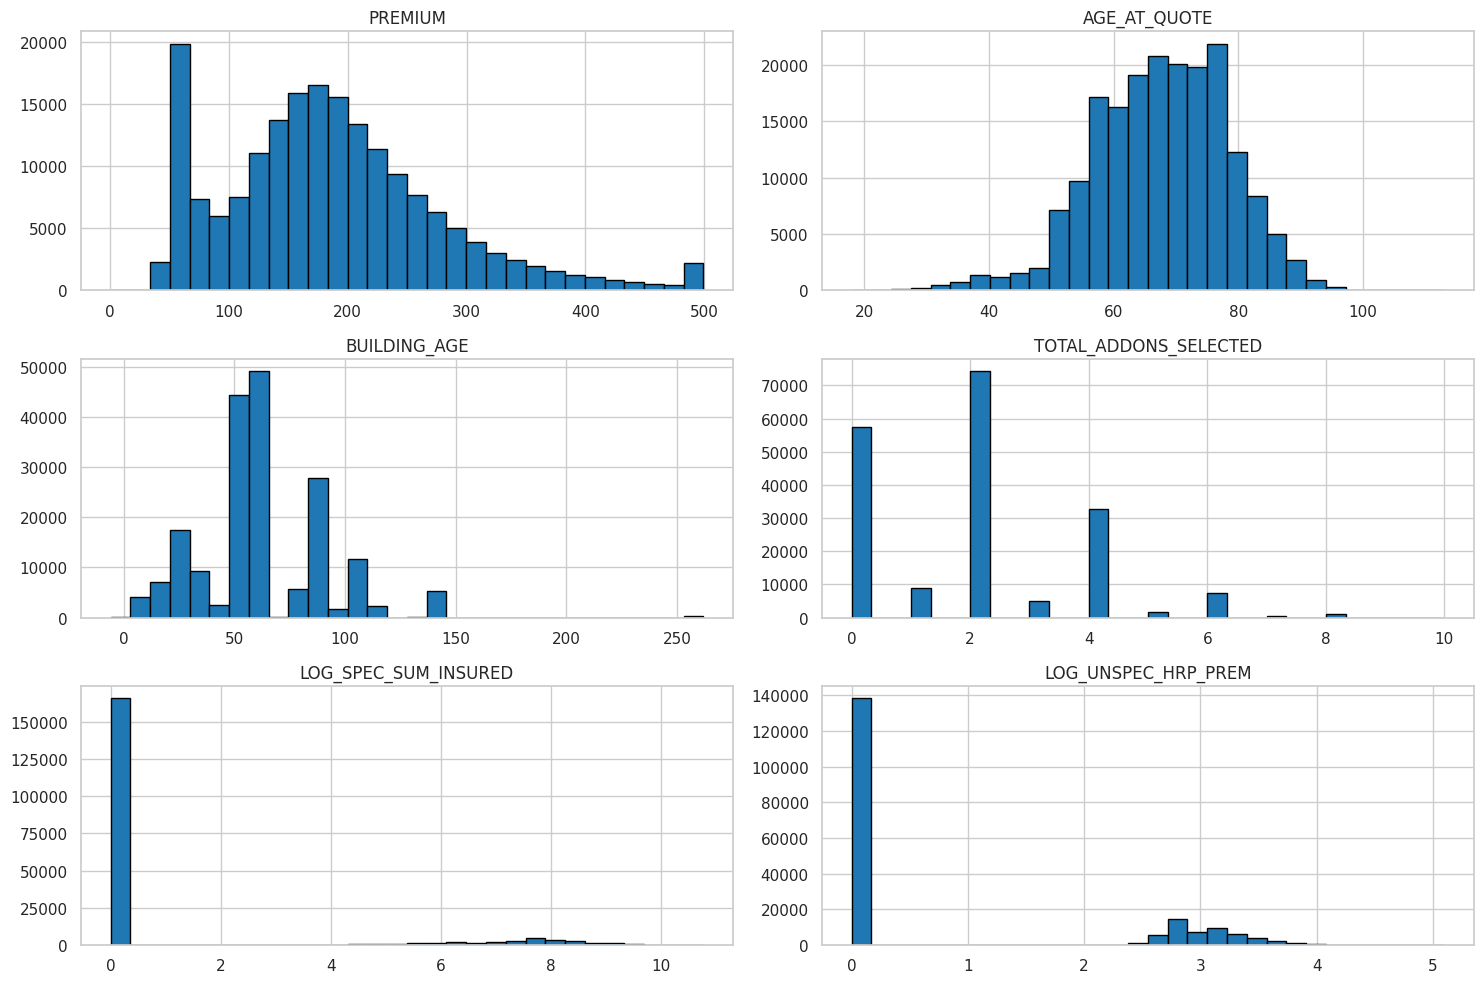

In [ ]:
# ----------------------------
# Histograms of Key Features
# ----------------------------
cont_vars = [
    "PREMIUM", "AGE_AT_QUOTE", "BUILDING_AGE",
    "TOTAL_ADDONS_SELECTED", "LOG_SPEC_SUM_INSURED", "LOG_UNSPEC_HRP_PREM"
]
df[cont_vars].hist(bins=30, figsize=(15, 10), color="#1f77b4", edgecolor="black")
#plt.suptitle("Distributions of Key Continuous Variables", fontsize=16)
plt.tight_layout()
plt.show()

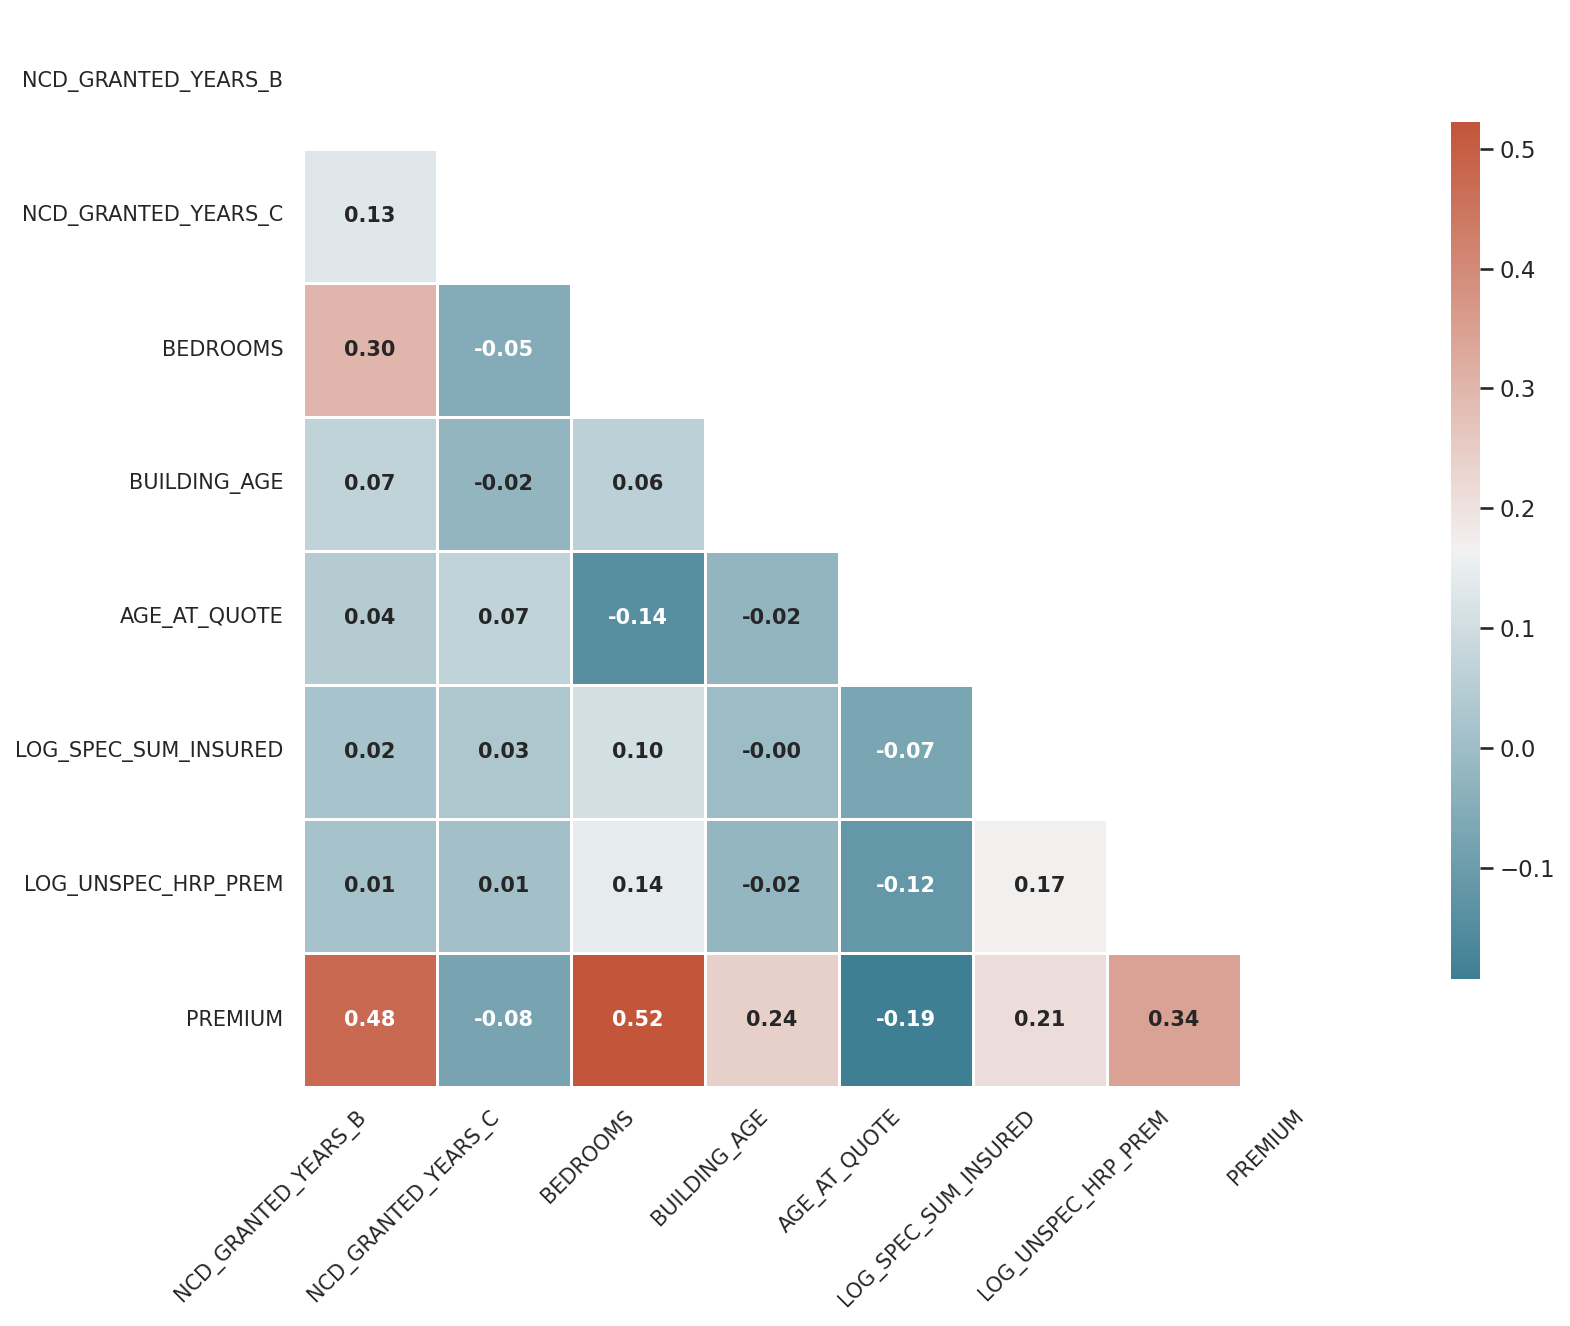

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# -------------------------------------------
# Select continuous numeric features
# -------------------------------------------
continuous_cols = [
    "NCD_GRANTED_YEARS_B",
    "NCD_GRANTED_YEARS_C",
    "BEDROOMS",
    "BUILDING_AGE",
    "AGE_AT_QUOTE",
    "LOG_SPEC_SUM_INSURED",
    "LOG_UNSPEC_HRP_PREM",
    "PREMIUM",
]

df_cont = df[continuous_cols]

# -------------------------------------------
# Compute correlation matrix
# -------------------------------------------
corr = df_cont.corr()

# -------------------------------------------
# Professional Heatmap Styling
# -------------------------------------------
plt.figure(figsize=(12, 9), dpi=150)

# Use seaborn white theme
sns.set_theme(style="white")

# Generate mask (optional, aesthetic diagonal cut)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Custom colour palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw heatmap
ax = sns.heatmap(
    corr,
    mask=mask,                                   # upper triangle masked for elegance
    annot=True,
    fmt=".2f",
    cmap=cmap,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "aspect": 30},
    square=True,
    annot_kws={"size": 10, "weight": "bold"},
)

# -------------------------------------------
# Formatting
# -------------------------------------------


# Improve label rotation & spacing
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Remove top and right spines for cleaner aesthetic
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

/tmp/ipython-input-4002605207.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("AddonsGroup")["PREMIUM"]


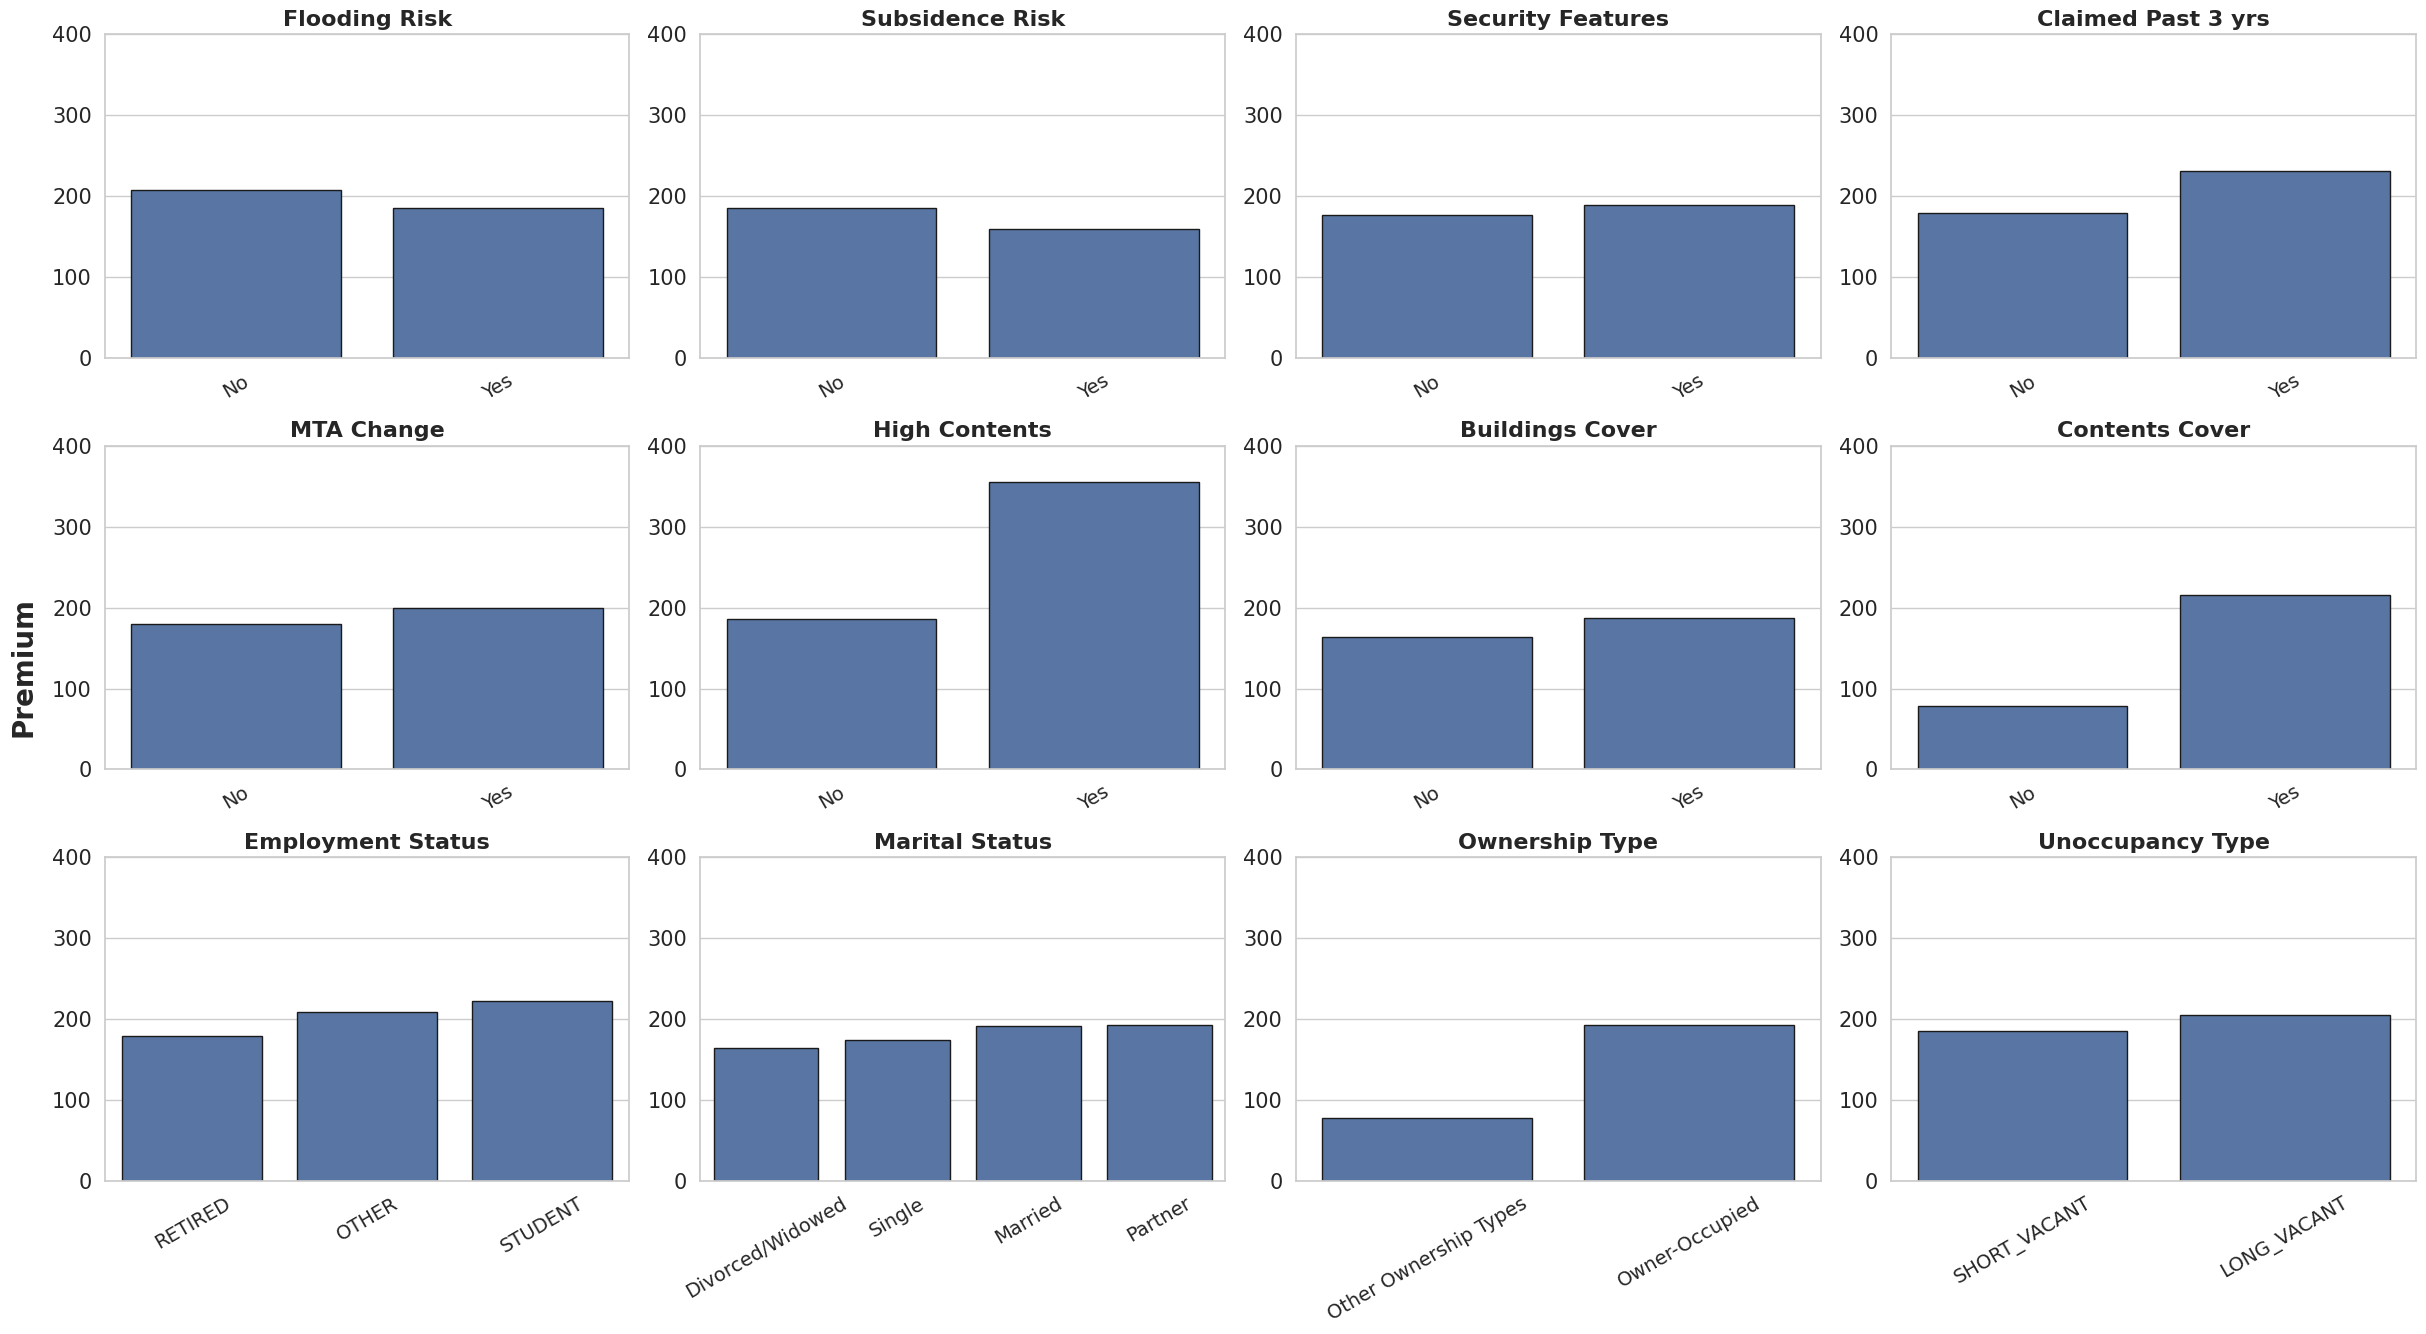

In [ ]:
# ============================================================================
#  EDA Plots - Key Features
# ============================================================================

import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_style("whitegrid")

# --- Pick important binary columns ---
important_binary = {
    "Flooding Risk": "HAS_FLOODING_RISK",
    "Subsidence Risk": "HAS_SUBSIDENCE_RISK",
    "Security Features": "HAS_SECURITY_FEATURES",
    "Claimed Past 3 yrs": "CLAIMED_PAST_3YRS",
    "MTA Change": "HAS_MTA_CHANGE",
    "High Contents": "HAS_HIGH_CONTENTS",
    "Buildings Cover": "HAS_BUILDINGS_COVER",
    "Contents Cover": "HAS_CONTENTS_COVER",
}

# --- Important multi-category groups ---
important_multi = {
    "Employment Status": "EMPLOYMENT_STATUS_",
    "Marital Status": "MARITAL_STATUS_",
    "Ownership Type": "OWNERSHIP.TYPE_",
    "Unoccupancy Type": "UNOCCUPANCY.TYPE_"
}

# --- Custom mappings ---
marital_map = {
    "B": "Single",
    "C": "Single",
    "N": "Single",
    "M": "Married",
    "PARTNER": "Partner",
    "PREVIOUSLY_MARRIED": "Divorced/Widowed"
}

ownership_map = {
    "8.0": "Owner-Occupied",
    "OTHER": "Other Ownership Types"
}

# --- Build plot list ---
all_plots = []

# Binary variables
for pretty, col in important_binary.items():
    if col not in df.columns:
        continue
    grp = (
        df.assign(**{pretty: df[col].map({0: "No", 1: "Yes"})})
          .groupby(pretty)["PREMIUM"]
          .agg(mean="mean")
          .reset_index()
    )
    all_plots.append((pretty, grp))

# Multi-category vars
for pretty, prefix in important_multi.items():
    dcols = [c for c in df.columns if c.startswith(prefix)]
    if not dcols:
        continue

    cat = df[dcols].idxmax(axis=1).str.replace(prefix, "", regex=False)

    # Apply custom mappings
    if pretty == "Marital Status":
        cat = cat.map(marital_map).fillna(cat)
    if pretty == "Ownership Type":
        cat = cat.map(ownership_map).fillna(cat)

    grp = (
        df.assign(**{pretty: cat})
          .groupby(pretty)["PREMIUM"]
          .agg(mean="mean")
          .reset_index()
          .sort_values("mean")
    )
    all_plots.append((pretty, grp))

# --- Add Total Addons Selected (binned groups) ---
addons_grp = (
    df.assign(AddonsGroup=pd.cut(
        df["TOTAL_ADDONS_SELECTED"],
        bins=[-1,0,2,5,df["TOTAL_ADDONS_SELECTED"].max()],
        labels=["0", "1-2", "3-5", "6+"]
    ))
      .groupby("AddonsGroup")["PREMIUM"]
      .agg(mean="mean")
      .reset_index()
)
all_plots.append(("Total Addons Selected", addons_grp))

# --- Grid layout: 3 rows × 4 cols ---
n = len(all_plots)
cols = 4
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4.5*rows))
axes = np.array(axes).reshape(-1)

# --- Find global max for y-axis ---
global_max = max(grp["mean"].max() for _, grp in all_plots)
ymax = math.ceil(global_max / 50) * 50  # round up to nearest 50

# --- Plot each subplot with bigger text ---
for i, (pretty, grp) in enumerate(all_plots[:rows*cols]):
    ax = axes[i]
    sns.barplot(x=pretty, y="mean", data=grp, color="#4C72B0", edgecolor="k", ax=ax)

    # Title and labels
    ax.set_title(f"{pretty}", fontsize=16, fontweight="bold")
    ax.set_ylabel("")
    ax.set_xlabel("", fontsize=14)

    # Tick labels (bigger numbers here)
    ax.tick_params(axis="x", rotation=30, labelsize=14, width=1.5)
    ax.tick_params(axis="y", labelsize=15, width=1.5)  # numbers on y-axis larger

    # Fixed y-scale
    ax.set_ylim(0, ymax)

# Hide unused axes
for k in range(i+1, rows*cols):
    fig.delaxes(axes[k])

fig.text(-0.01, 0.5, "Premium", va="center", rotation="vertical",
         fontsize=20, fontweight="bold")


plt.tight_layout()
plt.show()


## **Vanilla Models**

In [ ]:
def evaluate_model(name, model, data, fractions=[0.1,0.25,0.5,0.75,1.0], random_state=42):
    results = []
    for f in fractions:
        sub = stratified_subsample(data, frac=f, random_state=random_state)
        X = sub.drop(columns=["PREMIUM"])
        y = sub["PREMIUM"]
        X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,random_state=random_state)
        m = model.__class__(**model.get_params())
        if hasattr(m, "random_state"):
            setattr(m, "random_state", random_state)
        m.fit(X_tr, y_tr)
        p = m.predict(X_te)
        results.append({
            "Model": name, "Fraction": f,
            "R2": r2_score(y_te,p),
            "MAE": mean_absolute_error(y_te,p),
            "RMSE": np.sqrt(mean_squared_error(y_te,p)),
            "MAPE": mean_absolute_percentage_error(y_te,p)
        })
    return pd.DataFrame(results)

    models = [
    ("Lasso",            Lasso(alpha=1.0)),
    ("RandomForest",     RandomForestRegressor(n_estimators=100, random_state=42)),
    ("XGBoost",          XGBRegressor(n_estimators=100, random_state=42)),
    ("KNN",              KNeighborsRegressor()),
]

all_results = pd.concat(
    [evaluate_model(n, m, df) for n, m in models],
    ignore_index=True
)

# Print per-model
for name in all_results["Model"].unique():
    print(f"\n=== Results for {name} ===")
    print(all_results[all_results["Model"]==name]
          .to_string(index=False, float_format="%.4f"))


=== Results for Lasso ===
Model  Fraction     R2     MAE    RMSE   MAPE
Lasso    0.1000 0.6591 40.4359 54.6841 0.2694
Lasso    0.2500 0.6422 40.9791 55.5835 0.2656
Lasso    0.5000 0.6582 40.3034 54.3048 0.2645
Lasso    0.7500 0.6570 40.4629 54.6039 0.2668
Lasso    1.0000 0.6514 40.5005 54.7113 0.2665

=== Results for RandomForest ===
       Model  Fraction     R2     MAE    RMSE   MAPE
RandomForest    0.1000 0.7370 33.4693 48.0324 0.1952
RandomForest    0.2500 0.7197 34.0170 49.1904 0.1929
RandomForest    0.5000 0.7405 32.9788 47.3220 0.1879
RandomForest    0.7500 0.7385 33.2953 47.6780 0.1907
RandomForest    1.0000 0.7369 33.0321 47.5322 0.1881

=== Results for XGBoost ===
  Model  Fraction     R2     MAE    RMSE   MAPE
XGBoost    0.1000 0.7473 32.6685 47.0864 0.1900
XGBoost    0.2500 0.7432 32.3444 47.0849 0.1822
XGBoost    0.5000 0.7616 31.2631 45.3558 0.1766
XGBoost    0.7500 0.7636 31.3116 45.3322 0.1774
XGBoost    1.0000 0.7608 31.1753 45.3218 0.1764

=== Results for KNN ===
Mod